In [1]:
# 1 - SETUP Y DEPENDENCIAS
# ------------------------------------------------------------
# - Importa librerías
# - Fija semilla y dispositivo
# - Parámetros globales del problema (adimensionales)
# ------------------------------------------------------------

import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Reproducibilidad y dispositivo
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device( "cuda:3" if torch.cuda.is_available() else "cpu" )
torch.set_default_dtype(torch.float64)

# Parámetros físicos adimensionales
@dataclass
class Params:
    zeta: float = 0.05     # amortiguamiento adimensional
    kappa: float = 0.30    # acoplamiento adimensional (kc/k)
    A1: float = 1.0        # amplitud de F1(t) = A1 cos(omega t)
    A2: float = 0.6        # amplitud de F2(t) = A2 sin(omega t)
    omega: float = 1.3     # frecuencia adimensional de forzado

P = Params()

# Rango temporal y muestreo
N_PERIODS = 12
T_forzado = 2.0*math.pi/P.omega
t_ini, t_fin = 0.0, N_PERIODS*T_forzado

# Condiciones iniciales (transitorio; la PINN las usará)
x10, v10 = 0.0, 0.0
x20, v20 = 0.0, 0.0

# Muestreo de entrenamiento y evaluación
N_COL = 4000    # puntos de collocation (física)
N_IC  = 64      # puntos en t=0 para IC
USE_PERIODICITY = True     # imponemos x(t)~x(t+T) si se quiere régimen estacionario
N_PB  = 256     # puntos para periodicidad

# Fourier features
USE_FOURIER = True
N_HARMONICS = 6   # número de armónicos (1..N) de la frecuencia omega

# Entrenamiento
LR = 1e-3
EPOCHS = 4000
PRINT_EACH = 200
USE_LBFGS = True  # refinamiento final tipo PINN clásico

# Pesos de pérdidas
W_PHYS = 4.0
W_IC   = 5.0
W_PB   = 2.0

# Resolución de curvas
N_EVAL = 1200  # puntos para graficar curvas


In [2]:
# 2 - SOLUCIÓN ANALÍTICA (RÉGIMEN ESTACIONARIO) + IC CONSISTENTES
# ------------------------------------------------------------
# Respuesta estacionaria EXACTA para:
#   x'' + 2ζ x' + K x = g(t),  K = [[1+κ, -κ], [-κ, 1+κ]]
#   g(t) = [A1 cos(ω t), A2 sin(ω t)]
# En notación compleja:
#   (K - ω^2 I + i 2ζ ω I) X = G,  con G = [A1, -i A2]
# De donde:
#   x(t) = Re{X} cos(ωt) - Im{X} sin(ωt)
#   v(t) = -ω[ Re{X} sin(ωt) + Im{X} cos(ωt) ]
# En t=0:
#   x(0) = Re{X},  v(0) = -ω Im{X}
# ------------------------------------------------------------

import numpy as np
from typing import Tuple

def analytic_amplitudes(zeta: float, kappa: float, A1: float, A2: float, omega: float) -> np.ndarray:
    """Devuelve X = [X1, X2] (complejos) tal que (K - ω^2 I + i 2ζ ω I) X = G."""
    K = np.array([[1.0+kappa, -kappa],
                  [-kappa, 1.0+kappa]], dtype=np.complex128)
    I = np.eye(2, dtype=np.complex128)
    D = K - (omega**2)*I + 1j*2.0*zeta*omega*I  # rigidez dinámica compleja
    G = np.array([A1, -1j*A2], dtype=np.complex128)  # fuerzas complejas
    X = np.linalg.solve(D, G)  # [X1, X2]
    return X

def analytic_steady_state(t: np.ndarray, zeta: float, kappa: float, A1: float, A2: float, omega: float) -> Tuple[np.ndarray, np.ndarray]:
    """x1(t), x2(t) estacionarios (sin transitorio) a partir de X."""
    X = analytic_amplitudes(zeta, kappa, A1, A2, omega)
    Xr = X.real; Xi = X.imag
    cosw = np.cos(omega*t)
    sinw = np.sin(omega*t)
    x1 = Xr[0]*cosw - Xi[0]*sinw
    x2 = Xr[1]*cosw - Xi[1]*sinw
    return x1, x2

# --- Datos “reales” estacionarios en la rejilla t_eval ---
t_eval = np.linspace(t_ini, t_fin, N_EVAL)
x1_real, x2_real = analytic_steady_state(t_eval, P.zeta, P.kappa, P.A1, P.A2, P.omega)

# --- Ajuste de CONDICIONES INICIALES para que cuadren con la analítica ---
X = analytic_amplitudes(P.zeta, P.kappa, P.A1, P.A2, P.omega)
# En t=0: x(0)=Re{X}, v(0)=-ω Im{X}
x10 = float(X.real[0]); v10 = float(-P.omega * X.imag[0])
x20 = float(X.real[1]); v20 = float(-P.omega * X.imag[1])

# (Opcional) Comprobación rápida
print("IC ajustadas al estacionario:")
print(f"x1(0)={x10:.6f}  v1(0)={v10:.6f} | x2(0)={x20:.6f}  v2(0)={v20:.6f}")
print("Chequeo con curvas analíticas en t=0:")
print(f"x1_real[0]-x10 = {x1_real[0]-x10:+.3e}   x2_real[0]-x20 = {x2_real[0]-x20:+.3e}")


IC ajustadas al estacionario:
x1(0)=-1.018905  v1(0)=4.409558 | x2(0)=-0.538905  v2(0)=-5.158442
Chequeo con curvas analíticas en t=0:
x1_real[0]-x10 = +0.000e+00   x2_real[0]-x20 = +0.000e+00


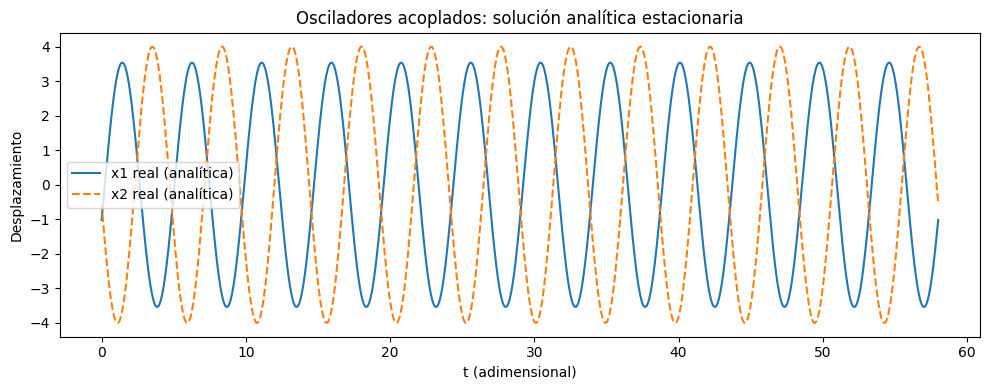

In [3]:
# 3 - GRÁFICA: DATOS REALES (ANALÍTICOS)
# ------------------------------------------------------------
# Dibuja x1(t) y x2(t) estacionarios para inspección visual.
# ------------------------------------------------------------

plt.figure(figsize=(10,4))
plt.plot(t_eval, x1_real, label="x1 real (analítica)")
plt.plot(t_eval, x2_real, label="x2 real (analítica)", linestyle="--")
plt.xlabel("t (adimensional)")
plt.ylabel("Desplazamiento")
plt.title("Osciladores acoplados: solución analítica estacionaria")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# 4 - PINN CON FOURIER FEATURES (DEFINICIONES)
# ------------------------------------------------------------
# - Codificador de tiempo con Fourier features
# - MLP flexible
# - Utilidades de derivadas, fuerzas, muestreo
# - Residuos físicos que aceptan modelo y codificador externos
# ------------------------------------------------------------
class FourierFeatures(nn.Module):
    def __init__(self, omega: float, n_harmonics: int):
        super().__init__()
        self.omega = omega
        self.n = n_harmonics

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        feats = [t]
        for n in range(1, self.n+1):
            feats.append(torch.sin(n*self.omega*t))
            feats.append(torch.cos(n*self.omega*t))
        return torch.cat(feats, dim=1)

class MLP(nn.Module):
    def __init__(self, n_in: int, n_out: int = 2, width: int = 128, depth: int = 5, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(n_in, width), act()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, n_out)]
        self.net = nn.Sequential(*layers)
        self.apply(self._init)

    @staticmethod
    def _init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# Construcción helpers
def build_ff(omega: float, n_harmonics: int, use_fourier: bool):
    if not use_fourier:
        return None
    return FourierFeatures(omega, n_harmonics).to(device)

def build_model(n_in: int, width: int, depth: int, act=nn.Tanh):
    return MLP(n_in=n_in, n_out=2, width=width, depth=depth, act=act).to(device)

def encode_time(ff, t: torch.Tensor) -> torch.Tensor:
    return ff(t) if ff is not None else t

# Derivadas
def ddt(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]

def ddtt(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    dy = ddt(y, t)
    return torch.autograd.grad(dy, t, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]

# Fuerza g(t) = [A1 cos(ωt), A2 sin(ωt)]
def g_batch(t: torch.Tensor, A1: float, A2: float, omega: float) -> torch.Tensor:
    g1 = A1*torch.cos(omega*t)
    g2 = A2*torch.sin(omega*t)
    return torch.cat([g1, g2], dim=1)

# Muestras
def sample_collocation(n: int) -> torch.Tensor:
    return (torch.rand(n,1, device=device)*(t_fin - t_ini) + t_ini).requires_grad_(True)

def sample_ic(n: int) -> torch.Tensor:
    return torch.zeros(n,1, device=device, requires_grad=True)

def sample_periodic(n: int) -> Tuple[torch.Tensor, torch.Tensor]:
    tA = (torch.rand(n,1, device=device)*(t_fin - t_ini - T_forzado) + t_ini).requires_grad_(True)
    tB = (tA + T_forzado).requires_grad_(True)
    return tA, tB

# Residuos físicos (general, acepta modelo y ff externos)
def physics_residuals(t: torch.Tensor, model: nn.Module, ff, zeta: float, kappa: float, A1: float, A2: float, omega: float):
    xin = encode_time(ff, t)
    x = model(xin)                  # (N,2) -> x1, x2
    x1, x2 = x[:,0:1], x[:,1:2]
    x1_t = ddt(x1, t); x2_t = ddt(x2, t)
    x1_tt = ddtt(x1, t); x2_tt = ddtt(x2, t)

    g = g_batch(t, A1, A2, omega)
    g1, g2 = g[:,0:1], g[:,1:2]

    # K = [[1+κ, -κ], [-κ, 1+κ]]
    r1 = x1_tt + 2*zeta*x1_t + (1+kappa)*x1 - kappa*x2 - g1
    r2 = x2_tt + 2*zeta*x2_t + (1+kappa)*x2 - kappa*x1 - g2
    return r1, r2, x1, x2, x1_t, x2_t


In [5]:
# 5 - PÉRDIDAS Y ENTRENAMIENTO (UTILIDADES)  [con tqdm]
# ------------------------------------------------------------
# - Define la loss total: física + IC (+ periodicidad opcional)
# - Función de entrenamiento reusable (Adam + opcional LBFGS)
# - Añade barras de progreso con tqdm (por época)
# ------------------------------------------------------------
from typing import Optional
from copy import deepcopy
import time
from tqdm.auto import tqdm


def loss_total(model: nn.Module, ff, use_periodicity: bool,
               n_col: int, n_ic: int, n_pb: int,
               w_phys: float, w_ic: float, w_pb: float):
    # Física
    t_col = sample_collocation(n_col)
    r1, r2, _, _, _, _ = physics_residuals(t_col, model, ff, P.zeta, P.kappa, P.A1, P.A2, P.omega)
    L_phys = (r1**2).mean() + (r2**2).mean()

    # ICs en t=0
    t0 = sample_ic(n_ic)
    _, _, x1_0_hat, x2_0_hat, v1_0_hat, v2_0_hat = physics_residuals(t0, model, ff, P.zeta, P.kappa, P.A1, P.A2, P.omega)
    L_ic = ((x1_0_hat - x10)**2).mean() + ((x2_0_hat - x20)**2).mean() \
         + ((v1_0_hat - v10)**2).mean() + ((v2_0_hat - v20)**2).mean()

    # Periodicidad (opcional)
    L_per = torch.tensor(0.0, device=device)
    if use_periodicity:
        tA, tB = sample_periodic(n_pb)
        xA = model(encode_time(ff, tA))
        xB = model(encode_time(ff, tB))
        dA = ddt(xA, tA)
        dB = ddt(xB, tB)
        L_per = ((xA - xB)**2).mean() + ((dA - dB)**2).mean()

    L = w_phys*L_phys + w_ic*L_ic + (w_pb*L_per if use_periodicity else 0.0)
    logs = {"phys": L_phys.item(), "ic": L_ic.item(), "per": (L_per.item() if use_periodicity else 0.0)}
    return L, logs

def train_run(width=128, depth=5, n_harmonics=6, use_fourier=True, use_periodicity=True,
              lr=1e-3, epochs=2000, print_each=200,
              n_col=4000, n_ic=64, n_pb=256, w_phys=1.0, w_ic=5.0, w_pb=1.0, use_lbfgs=True,
              seed=1234, save_checkpoints=False,
              show_epoch_bar=True, epoch_bar_desc=None):   # <-- NUEVOS parámetros
    # Semillas
    np.random.seed(seed); torch.manual_seed(seed)

    # Entrada
    n_in = 1 + (2*n_harmonics if use_fourier else 0)
    ff = build_ff(P.omega, n_harmonics, use_fourier)
    model = build_model(n_in, width=width, depth=depth)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"total": [], "phys": [], "ic": [], "per": []}
    checkpoints = []  # (epoch, x1, x2) sobre rejilla
    t_grid = torch.linspace(t_ini, t_fin, N_EVAL, device=device).view(-1,1).requires_grad_(True)

    t0_run = time.time()

    epoch_iter = range(1, epochs+1)
    if show_epoch_bar:
        epoch_iter = tqdm(epoch_iter, total=epochs, leave=True,
                          desc=epoch_bar_desc or "Entrenamiento")

    for epoch in epoch_iter:
        optimizer.zero_grad()
        L, logs = loss_total(model, ff, use_periodicity, n_col, n_ic, n_pb, w_phys, w_ic, w_pb)
        L.backward()
        optimizer.step()

        history["total"].append(L.item())
        history["phys"].append(logs["phys"])
        history["ic"].append(logs["ic"])
        history["per"].append(logs["per"])

        if show_epoch_bar:
            # mostrar métricas compactas
            epoch_iter.set_postfix(loss=float(L.item()), phys=float(logs["phys"]), ic=float(logs["ic"]))

        if save_checkpoints and (epoch % print_each == 0 or epoch == 1):
            with torch.no_grad():
                x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
            checkpoints.append((epoch, x_hat[:,0].copy(), x_hat[:,1].copy()))

    if use_lbfgs:
        def closure():
            optimizer_lbfgs.zero_grad()
            Lc, _ = loss_total(model, ff, use_periodicity, n_col, n_ic, n_pb, w_phys, w_ic, w_pb)
            Lc.backward()
            return Lc
        optimizer_lbfgs = optim.LBFGS(model.parameters(), max_iter=500,
                                      tolerance_grad=1e-9, tolerance_change=1e-12,
                                      line_search_fn="strong_wolfe")
        L_final = optimizer_lbfgs.step(closure).item()
        history["total"].append(L_final)
        if save_checkpoints:
            with torch.no_grad():
                x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
            checkpoints.append((epochs+999, x_hat[:,0].copy(), x_hat[:,1].copy()))

    # Métrica MSE vs analítica (estacionaria)
    with torch.no_grad():
        x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
    t_eval_local = t_grid.detach().cpu().numpy().squeeze()
    x1r, x2r = analytic_steady_state(t_eval_local, P.zeta, P.kappa, P.A1, P.A2, P.omega)
    val_mse = float(np.mean((x_hat[:,0]-x1r)**2 + (x_hat[:,1]-x2r)**2))

    state = deepcopy(model.state_dict())
    elapsed = time.time()-t0_run
    meta = {"width": width, "depth": depth, "n_harmonics": n_harmonics, "use_fourier": use_fourier,
            "use_periodicity": use_periodicity, "lr": lr, "epochs": epochs, "seed": seed,
            "n_col": n_col, "n_ic": n_ic, "n_pb": n_pb, "use_lbfgs": use_lbfgs, "elapsed_sec": elapsed}

    return model, ff, state, history, checkpoints, val_mse, meta


In [6]:
# 6 - GRID SEARCH: entrenar SOLO las 10 mejores combinaciones
# ------------------------------------------------------------
# - Usa las 10 combinaciones que ya identificaste como mejores
# - Reentrena cada una con sus épocas y ajustes originales
# - Barra global y barra por época
# - Genera df_results para celdas 7–11
# ------------------------------------------------------------
import pandas as pd
from tqdm.auto import tqdm


# Arquitecturas (mantenemos las 8 definidas para coherencia con el resto)
architectures = [
    {"name":"MLP_w64_d3",   "width":64,  "depth":3},
]

# Generador de HPs (mismo mapeo que Celda 6 anterior)
def build_hp_grid():
    letters = [
        ("A", {"lr":2e-3, "epochs":1500, "n_harmonics":2}),
        ("B", {"lr":1e-3, "epochs":2000, "n_harmonics":3}),
        ("C", {"lr":7e-4, "epochs":2500, "n_harmonics":4}),
        ("D", {"lr":5e-4, "epochs":3000, "n_harmonics":5}),
        ("E", {"lr":3e-4, "epochs":4000, "n_harmonics":6}),
    ]
    configs = [
        (1, {"use_periodicity":False, "use_lbfgs":False}),
        (2, {"use_periodicity":False, "use_lbfgs":True}),
        (3, {"use_periodicity":True,  "use_lbfgs":True}),
        (4, {"use_periodicity":True,  "use_lbfgs":False}),
    ]
    grid = []
    for letter, base in letters:
        for idx, flags in configs:
            name = f"HP_{letter}_{idx}"
            epochs = base["epochs"]
            print_each = max(200, epochs//5)
            grid.append({
                "name": name,
                "lr": base["lr"],
                "epochs": epochs,
                "n_harmonics": base["n_harmonics"],
                "use_periodicity": flags["use_periodicity"],
                "use_lbfgs": flags["use_lbfgs"],
                "print_each": print_each,
            })
    return grid

hp_grid = build_hp_grid()

# --- Top-10 proporcionado por ti (en ese orden) ---
top10_pairs = [
    ("MLP_w64_d3",  "HP_C_2"),
    ("MLP_w64_d3",  "HP_C_1"),
]

# Pequeñas utilidades para localizar specs por nombre
def get_arch(name: str):
    m = [a for a in architectures if a["name"] == name]
    assert len(m)==1, f"Arquitectura '{name}' no encontrada"
    return m[0]

def get_hp(name: str):
    m = [h for h in hp_grid if h["name"] == name]
    assert len(m)==1, f"HP '{name}' no encontrado"
    return m[0]

# Entrenar SOLO esas 10 combinaciones
all_results = []
runs = {}

print(f">>> Entrenando solo las {len(top10_pairs)} mejores combinaciones (con IC ajustadas)...")
with tqdm(total=len(top10_pairs), desc="Top-10 (runs)", position=0) as pbar:
    for arch_name, hp_name in top10_pairs:
        arch = get_arch(arch_name)
        hp   = get_hp(hp_name)
        key  = f"{arch['name']}__{hp['name']}"
        epoch_desc = f"{arch['name']} | {hp['name']}"

        model_g, ff_g, state_g, hist_g, cpts_g, mse_g, meta_g = train_run(
            width=arch["width"], depth=arch["depth"],
            n_harmonics=hp["n_harmonics"], use_fourier=True, use_periodicity=hp["use_periodicity"],
            lr=hp["lr"], epochs=hp["epochs"], print_each=hp["print_each"],
            n_col=N_COL, n_ic=N_IC, n_pb=N_PB,
            w_phys=W_PHYS, w_ic=W_IC, w_pb=W_PB,
            use_lbfgs=hp["use_lbfgs"], seed=SEED, save_checkpoints=False,
            show_epoch_bar=True, epoch_bar_desc=epoch_desc
        )

        all_results.append({
            "arch": arch["name"],
            "hp": hp["name"],
            "val_mse": mse_g,
            "final_loss": hist_g["total"][-1],
            "epochs": hp["epochs"],
            "lr": hp["lr"],
            "n_harmonics": hp["n_harmonics"],
            "use_periodicity": hp["use_periodicity"],
            "use_lbfgs": hp["use_lbfgs"],
            "width": arch["width"],
            "depth": arch["depth"],
            "elapsed_sec": meta_g["elapsed_sec"]
        })
        runs[key] = {"state": state_g, "meta": meta_g, "history": hist_g, "arch": arch, "hp": hp}
        pbar.update(1)

# df_results FINAL = solo estas 10 combinaciones (ordenadas por MSE)
df_results = pd.DataFrame(all_results).sort_values(by="val_mse", ascending=True).reset_index(drop=True)
print("\nTop-10 (reentrenado con IC analíticas) por MSE:")
print(df_results)


>>> Entrenando solo las 2 mejores combinaciones (con IC ajustadas)...


Top-10 (runs):   0%|          | 0/2 [00:00<?, ?it/s]

MLP_w64_d3 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]


Top-10 (reentrenado con IC analíticas) por MSE:
         arch      hp   val_mse  final_loss  epochs      lr  n_harmonics  \
0  MLP_w64_d3  HP_C_2  0.009760    0.028236    2500  0.0007            4   
1  MLP_w64_d3  HP_C_1  0.010079    0.027999    2500  0.0007            4   

   use_periodicity  use_lbfgs  width  depth  elapsed_sec  
0            False       True     64      3    79.346466  
1            False      False     64      3    80.171961  


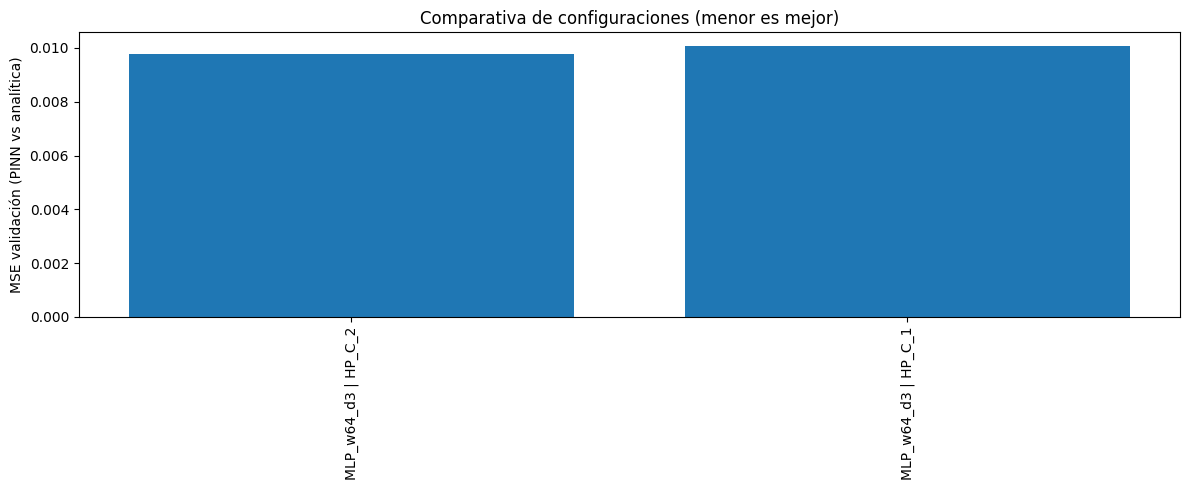

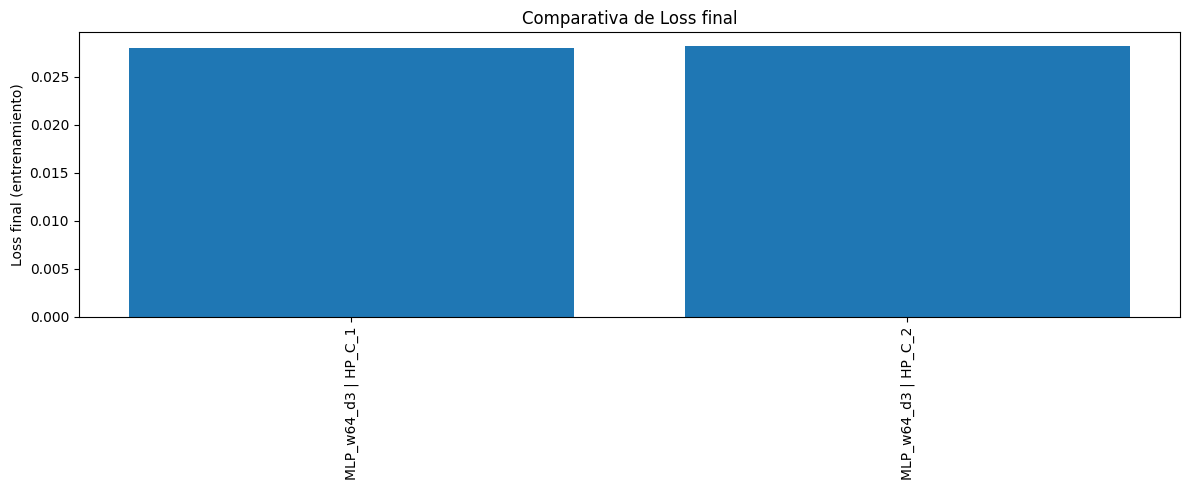

In [7]:
# 7 - GRID SEARCH: gráficas comparativas
# ------------------------------------------------------------
# - Barras de MSE vs analítica por ejecución (ordenadas)
# - Barras de Loss final
# ------------------------------------------------------------
labels = [f"{r['arch']} | {r['hp']}" for r in all_results]
mse_vals = [r["val_mse"] for r in all_results]
order = np.argsort(mse_vals)

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(labels)), np.array(mse_vals)[order])
plt.xticks(np.arange(len(labels)), np.array(labels)[order], rotation=90)
plt.ylabel("MSE validación (PINN vs analítica)")
plt.title("Comparativa de configuraciones (menor es mejor)")
plt.tight_layout()
plt.show()

final_losses = [r["final_loss"] for r in all_results]
order2 = np.argsort(final_losses)

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(labels)), np.array(final_losses)[order2])
plt.xticks(np.arange(len(labels)), np.array(labels)[order2], rotation=90)
plt.ylabel("Loss final (entrenamiento)")
plt.title("Comparativa de Loss final")
plt.tight_layout()
plt.show()


In [8]:
# 8 - SELECCIÓN MEJOR CONFIG + REENTRENAMIENTO CON CHECKPOINTS
# ------------------------------------------------------------
# - Selecciona la mejor por MSE
# - Reentrena guardando checkpoints para animación
# ------------------------------------------------------------
best_row = df_results.iloc[0]
best_arch_name = best_row["arch"]
best_hp_name   = best_row["hp"]
print("Mejor configuración encontrada:")
print(best_row)

# Recuperar specs
arch_best = None
for a in architectures:
    if a["name"] == best_arch_name:
        arch_best = a; break
hp_best = None
for h in hp_grid:
    if h["name"] == best_hp_name:
        hp_best = h; break

# Reentrenar con checkpoints
model_best, ff_best, state_best, history_best, checkpoints_best, mse_best, meta_best = train_run(
    width=arch_best["width"], depth=arch_best["depth"],
    n_harmonics=hp_best["n_harmonics"], use_fourier=True, use_periodicity=hp_best["use_periodicity"],
    lr=hp_best["lr"], epochs=hp_best["epochs"], print_each=hp_best["print_each"],
    n_col=N_COL, n_ic=N_IC, n_pb=N_PB, w_phys=W_PHYS, w_ic=W_IC, w_pb=W_PB, use_lbfgs=hp_best["use_lbfgs"],
    seed=SEED, save_checkpoints=True
)
print("MSE de la mejor config (reentrenada):", mse_best)

best_bundle = {
    "arch": arch_best, "hp": hp_best,
    "state": state_best, "history": history_best,
    "checkpoints": checkpoints_best, "meta": meta_best
}


Mejor configuración encontrada:
arch               MLP_w64_d3
hp                     HP_C_2
val_mse               0.00976
final_loss           0.028236
epochs                   2500
lr                     0.0007
n_harmonics                 4
use_periodicity         False
use_lbfgs                True
width                      64
depth                       3
elapsed_sec         79.346466
Name: 0, dtype: object


Entrenamiento:   0%|          | 0/2500 [00:00<?, ?it/s]

MSE de la mejor config (reentrenada): 0.009759531697267048


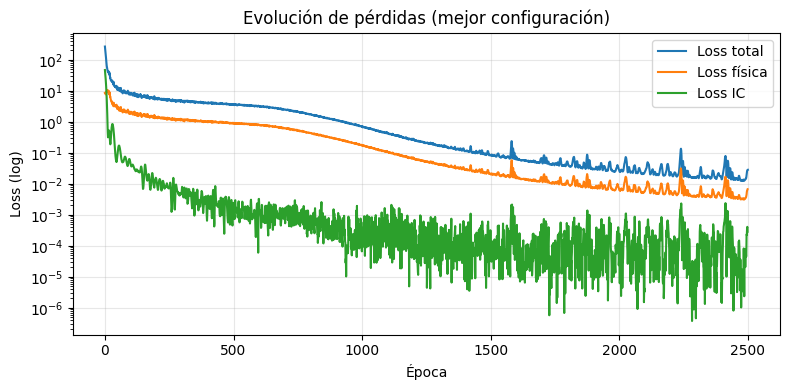

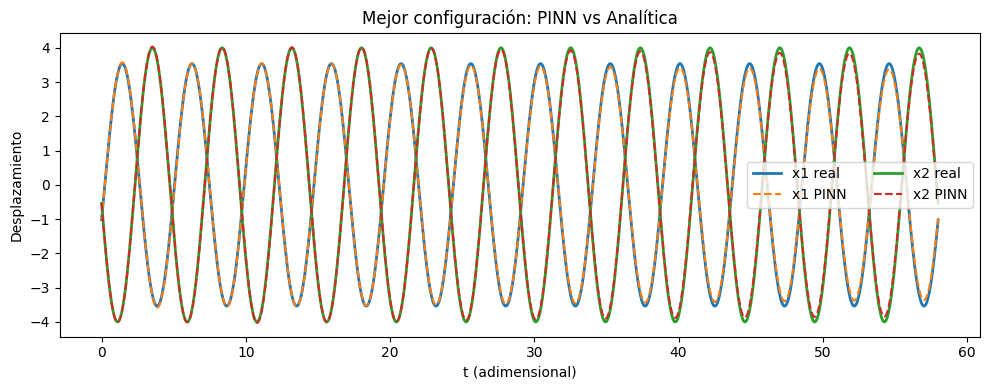

In [9]:
# 9 - GRÁFICAS DE PÉRDIDAS (MEJOR CONFIG) Y COMPARACIÓN CURVAS
# ------------------------------------------------------------
# - Curvas de pérdidas para la mejor configuración
# - Comparación PINN vs analítica (misma rejilla)
# ------------------------------------------------------------
# Pérdidas
plt.figure(figsize=(8,4))
plt.plot(best_bundle["history"]["total"], label="Loss total")
plt.plot(best_bundle["history"]["phys"], label="Loss física")
plt.plot(best_bundle["history"]["ic"],   label="Loss IC")
if best_bundle["hp"]["use_periodicity"]:
    plt.plot(best_bundle["history"]["per"], label="Loss periodicidad")
plt.yscale("log")
plt.xlabel("Época")
plt.ylabel("Loss (log)")
plt.title("Evolución de pérdidas (mejor configuración)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Comparación de curvas finales
t_grid_best = torch.linspace(t_ini, t_fin, N_EVAL, device=device).view(-1,1).requires_grad_(True)
ff_vis = build_ff(P.omega, best_bundle["hp"]["n_harmonics"], True)
n_in_best = 1 + 2*best_bundle["hp"]["n_harmonics"]
model_vis = build_model(n_in_best, width=best_bundle["arch"]["width"], depth=best_bundle["arch"]["depth"])
model_vis.load_state_dict(best_bundle["state"])

with torch.no_grad():
    x_hat_best = model_vis(encode_time(ff_vis, t_grid_best)).detach().cpu().numpy()

t_eval_best = t_grid_best.detach().cpu().numpy().squeeze()
x1r_best, x2r_best = analytic_steady_state(t_eval_best, P.zeta, P.kappa, P.A1, P.A2, P.omega)

plt.figure(figsize=(10,4))
plt.plot(t_eval_best, x1r_best, label="x1 real", linewidth=2)
plt.plot(t_eval_best, x_hat_best[:,0], "--", label="x1 PINN")
plt.plot(t_eval_best, x2r_best, label="x2 real", linewidth=2)
plt.plot(t_eval_best, x_hat_best[:,1], "--", label="x2 PINN")
plt.xlabel("t (adimensional)")
plt.ylabel("Desplazamiento")
plt.title("Mejor configuración: PINN vs Analítica")
plt.legend(ncols=2)
plt.tight_layout()
plt.show()


Reentrenando para animación (checkpoint por época)...


MLP_w64_d3 | HP_C_2 (anim):   0%|          | 0/2500 [00:00<?, ?it/s]

MSE animación (reentrenado denso): 0.0098


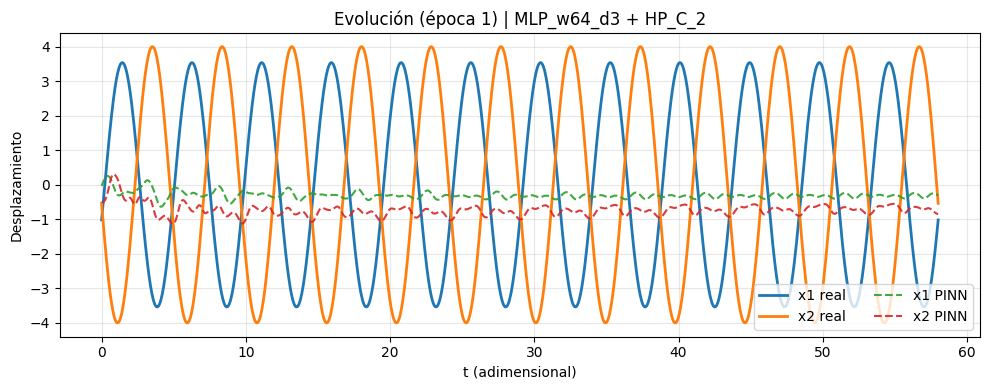

Animación guardada en 'anim_epoch_by_epoch.gif' (fps=24)


In [10]:
# 10 - ANIMACIÓN DETALLADA: ÉPOCA A ÉPOCA (más rápida)
# ----------------------------------------------------
# Reentrena guardando un checkpoint por ÉPOCA y anima la evolución x1/x2.

# === Ajustes de velocidad ===
ANIM_INTERVAL_MS = 40   # -> menor = más rápido en Jupyter
SAVE_FPS         = 24   # -> mayor = más rápido en el GIF final

# 1) Reentrenar SOLO para animación (checkpoint por época)
arch_best = best_bundle["arch"]
hp_best   = best_bundle["hp"]

print("Reentrenando para animación (checkpoint por época)...")
model_anim, ff_anim, state_anim, history_anim, checkpoints_dense, mse_anim, meta_anim = train_run(
    width=arch_best["width"], depth=arch_best["depth"],
    n_harmonics=hp_best["n_harmonics"], use_fourier=True, use_periodicity=hp_best["use_periodicity"],
    lr=hp_best["lr"], epochs=hp_best["epochs"], print_each=1,          # checkpoint CADA ÉPOCA
    n_col=N_COL, n_ic=N_IC, n_pb=N_PB, w_phys=W_PHYS, w_ic=W_IC, w_pb=W_PB,
    use_lbfgs=hp_best["use_lbfgs"], seed=SEED, save_checkpoints=True,
    show_epoch_bar=True, epoch_bar_desc=f"{arch_best['name']} | {hp_best['name']} (anim)"
)
print(f"MSE animación (reentrenado denso): {mse_anim:.4f}")

# 2) Referencia analítica
t_grid_anim = torch.linspace(t_ini, t_fin, N_EVAL, device=device).view(-1,1).requires_grad_(True)
t_eval_anim = t_grid_anim.detach().cpu().numpy().squeeze()
x1_real_anim, x2_real_anim = analytic_steady_state(t_eval_anim, P.zeta, P.kappa, P.A1, P.A2, P.omega)

# 3) Animación: una frame por época (más rápida)
fig, ax = plt.subplots(figsize=(10,4))
line_real1, = ax.plot(t_eval_anim, x1_real_anim, label="x1 real", linewidth=2)
line_real2, = ax.plot(t_eval_anim, x2_real_anim, label="x2 real", linewidth=2)
line_hat1,  = ax.plot(t_eval_anim, checkpoints_dense[0][1], "--", label="x1 PINN", alpha=0.9)
line_hat2,  = ax.plot(t_eval_anim, checkpoints_dense[0][2], "--", label="x2 PINN", alpha=0.9)
ax.set_xlabel("t (adimensional)")
ax.set_ylabel("Desplazamiento")
ax.set_title(f"Evolución (época {checkpoints_dense[0][0]}) | {arch_best['name']} + {hp_best['name']}")
ax.legend(ncols=2)
ax.grid(True, alpha=0.3)

def update_epoch(frame_idx):
    ep, x1h, x2h = checkpoints_dense[frame_idx]
    line_hat1.set_ydata(x1h)
    line_hat2.set_ydata(x2h)
    ax.set_title(f"Evolución (época {ep}) | {arch_best['name']} + {hp_best['name']}")
    return line_hat1, line_hat2

anim_epoch = FuncAnimation(
    fig, update_epoch,
    frames=len(checkpoints_dense),
    interval=ANIM_INTERVAL_MS,   # << más rápido en notebook
    blit=False, repeat=True
)
plt.tight_layout()
plt.show()

# (Opcional) Guardar GIF más rápido
try:
    anim_epoch.save("anim_epoch_by_epoch.gif", writer="pillow", fps=SAVE_FPS)  # << más rápido en GIF
    print(f"Animación guardada en 'anim_epoch_by_epoch.gif' (fps={SAVE_FPS})")
except Exception as e:
    print("No se pudo guardar el GIF. Error:", e)


In [11]:
# 11 - ANIMACIÓN PROGRESIVA (ensamblado manual con Pillow, sin FuncAnimation.save) [FIX]
# --------------------------------------------------------------------------------------
# Genera el GIF dibujando frame a frame y ensamblándolo con Pillow.
# Fix clave: pasar LISTAS a set_data() para puntos (no escalares).

import numpy as np
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# === Parámetros de animación ===
FRAME_STEP    = 1     # submuestreo (2,3,5...) para aligerar tamaño/tiempo
MAX_FRAMES    = None  # por ej. 800 para limitar; None = todos
DURATION_MS   = 20    # ms por frame (menor = más rápido)

# 1) Reconstruir predicción final y analítica
ff_final = build_ff(P.omega, best_bundle["hp"]["n_harmonics"], True)
n_in_best = 1 + 2*best_bundle["hp"]["n_harmonics"]
model_final = build_model(n_in_best, width=best_bundle["arch"]["width"], depth=best_bundle["arch"]["depth"])
model_final.load_state_dict(best_bundle["state"])

t_grid_final = torch.linspace(t_ini, t_fin, N_EVAL, device=device).view(-1,1)
with torch.no_grad():
    x_hat_final_stream = model_final(encode_time(ff_final, t_grid_final)).detach().cpu().numpy()

t_eval_stream = t_grid_final.detach().cpu().numpy().ravel()
x1_real_stream, x2_real_stream = analytic_steady_state(
    t_eval_stream, P.zeta, P.kappa, P.A1, P.A2, P.omega
)

# 2) Índices de frames robustos
indices = np.arange(len(t_eval_stream), dtype=int)
if FRAME_STEP > 1:
    indices = indices[::FRAME_STEP]
if (MAX_FRAMES is not None) and (len(indices) > MAX_FRAMES):
    factor = int(np.ceil(len(indices)/MAX_FRAMES))
    indices = indices[::max(1, factor)]
# asegúrate de incluir el último
if len(indices) == 0 or indices[-1] != len(t_eval_stream)-1:
    indices = np.append(indices, len(t_eval_stream)-1)

# 3) Preparar figura y canvas Agg
fig, ax = plt.subplots(figsize=(10,4))
canvas = FigureCanvas(fig)   # backend Agg para rasterizar a array

# Límites y estilo
ymin = min(x1_real_stream.min(), x2_real_stream.min(),
           x_hat_final_stream[:,0].min(), x_hat_final_stream[:,1].min())
ymax = max(x1_real_stream.max(), x2_real_stream.max(),
           x_hat_final_stream[:,0].max(), x_hat_final_stream[:,1].max())
pad = 0.05*(ymax - ymin + 1e-9)

ax.set_xlim(t_eval_stream[0], t_eval_stream[-1])
ax.set_ylim(ymin - pad, ymax + pad)
ax.set_xlabel("t (adimensional)")
ax.set_ylabel("Desplazamiento")
ax.set_title("Revelado temporal: PINN final vs Analítica")
ax.grid(True, alpha=0.3)

# Líneas y puntos
(line_real1_s,) = ax.plot([], [], label="x1 real", linewidth=2)
(line_real2_s,) = ax.plot([], [], label="x2 real", linewidth=2)
(line_hat1_s,)  = ax.plot([], [], "--", label="x1 PINN", alpha=0.9)
(line_hat2_s,)  = ax.plot([], [], "--", label="x2 PINN", alpha=0.9)
(pt_real1,)     = ax.plot([], [], "o", markersize=4)
(pt_real2,)     = ax.plot([], [], "o", markersize=4)
(pt_hat1,)      = ax.plot([], [], "o", markersize=4)
(pt_hat2,)      = ax.plot([], [], "o", markersize=4)
ax.legend(ncols=2)

# 4) Generar frames y ensamblar GIF con Pillow
frames = []
for k in indices:
    k = int(k)
    t_k = t_eval_stream[:k+1]

    # Actualizar líneas
    line_real1_s.set_data(t_k, x1_real_stream[:k+1])
    line_real2_s.set_data(t_k, x2_real_stream[:k+1])
    line_hat1_s.set_data(t_k, x_hat_final_stream[:k+1, 0])
    line_hat2_s.set_data(t_k, x_hat_final_stream[:k+1, 1])

    # ⚠️ FIX: set_data espera secuencias, no escalares
    pt_real1.set_data([t_eval_stream[k]], [x1_real_stream[k]])
    pt_real2.set_data([t_eval_stream[k]], [x2_real_stream[k]])
    pt_hat1.set_data([t_eval_stream[k]], [x_hat_final_stream[k,0]])
    pt_hat2.set_data([t_eval_stream[k]], [x_hat_final_stream[k,1]])

    # Render a píxeles y convierte a PIL Image
    canvas.draw()
    buf = np.asarray(canvas.buffer_rgba())  # (H,W,4) uint8
    frames.append(Image.fromarray(buf, mode="RGBA").convert("RGB"))

# Guardar GIF
if len(frames) == 0:
    raise RuntimeError("No se generaron frames (índices vacíos). Revisa N_EVAL/FRAME_STEP/MAX_FRAMES.")
elif len(frames) == 1:
    frames[0].save("anim_stream_progressive.gif")
else:
    frames[0].save(
        "anim_stream_progressive.gif",
        save_all=True,
        append_images=frames[1:],
        duration=DURATION_MS,
        loop=0,
        optimize=False
    )

plt.close(fig)
print(f"GIF guardado: 'anim_stream_progressive.gif' | frames={len(frames)}, duration={DURATION_MS} ms")


GIF guardado: 'anim_stream_progressive.gif' | frames=1200, duration=20 ms


In [12]:
# 12 - APLICAR LA MEJOR CONFIGURACIÓN AL CONTEXTO GLOBAL
# ------------------------------------------------------------
# - Sobrescribe globals 'model', 'ff', 'N_HARMONICS', 'USE_FOURIER',
#   para reutilizar en posibles celdas posteriores
# ------------------------------------------------------------
USE_FOURIER = True
N_HARMONICS = best_bundle["hp"]["n_harmonics"]
ff = build_ff(P.omega, N_HARMONICS, USE_FOURIER)
n_in = 1 + 2*N_HARMONICS
model = build_model(n_in, width=best_bundle["arch"]["width"], depth=best_bundle["arch"]["depth"])
model.load_state_dict(best_bundle["state"])
print("Mejor arquitectura:", best_bundle["arch"])
print("Mejores hiperparámetros:", best_bundle["hp"])


Mejor arquitectura: {'name': 'MLP_w64_d3', 'width': 64, 'depth': 3}
Mejores hiperparámetros: {'name': 'HP_C_2', 'lr': 0.0007, 'epochs': 2500, 'n_harmonics': 4, 'use_periodicity': False, 'use_lbfgs': True, 'print_each': 500}


In [15]:
# SR1 - EXTRAER DATOS ANALÍTICOS DISCRETIZADOS PARA SR
# ----------------------------------------------------
# - Discretiza x1(t), x2(t) y sus derivadas v1(t), v2(t), a1(t), a2(t)
# - Construye residuales R1 y R2 (que equivalen a F1 y F2)
# - Exporta CSV para PySR
import numpy as np
import pandas as pd

# Utilidades analíticas (derivadas exactas de la solución estacionaria)
# Si X = Re(X) + i Im(X), entonces:
# x(t) = Re(X) cos(ωt) - Im(X) sin(ωt)
# v(t) = dx/dt = -ω[ Re(X) sin(ωt) + Im(X) cos(ωt) ]
# a(t) = d2x/dt2 = -ω^2 x(t)
def analytic_xva_arrays(t: np.ndarray, zeta: float, kappa: float, A1: float, A2: float, omega: float):
    X = analytic_amplitudes(zeta, kappa, A1, A2, omega)  # complejos [X1, X2]
    Xr, Xi = X.real, X.imag
    cosw, sinw = np.cos(omega*t), np.sin(omega*t)

    x1 = Xr[0]*cosw - Xi[0]*sinw
    x2 = Xr[1]*cosw - Xi[1]*sinw

    v1 = -omega*(Xr[0]*sinw + Xi[0]*cosw)
    v2 = -omega*(Xr[1]*sinw + Xi[1]*cosw)

    a1 = -omega**2 * x1
    a2 = -omega**2 * x2
    return x1, v1, a1, x2, v2, a2

# Rejilla temporal (usamos la misma que t_eval del notebook)
t_sr = np.linspace(t_ini, t_fin, N_EVAL)

# x, v, a analíticos en régimen estacionario
x1, v1, a1, x2, v2, a2 = analytic_xva_arrays(t_sr, P.zeta, P.kappa, P.A1, P.A2, P.omega)

# Residuales (lado izquierdo del sistema):  R1 = a1 + 2ζ v1 + (1+κ)x1 - κ x2,  R2 = a2 + 2ζ v2 + (1+κ)x2 - κ x1
R1 = a1 + 2.0*P.zeta*v1 + (1.0+P.kappa)*x1 - P.kappa*x2
R2 = a2 + 2.0*P.zeta*v2 + (1.0+P.kappa)*x2 - P.kappa*x1

# Verdaderas forzantes (para referencia)
F1_true = P.A1*np.cos(P.omega*t_sr)
F2_true = P.A2*np.sin(P.omega*t_sr)

# DataFrame
df_sr = pd.DataFrame({
    "t": t_sr,
    "x1": x1, "v1": v1, "a1": a1,
    "x2": x2, "v2": v2, "a2": a2,
    "R1": R1, "R2": R2,          # objetivos para SR: R1 ~ F1(t), R2 ~ F2(t)
    "F1_true": F1_true, "F2_true": F2_true
})

df_sr.to_csv("sr_dataset_analytic_coupled.csv", index=False)
print("Guardado -> sr_dataset_analytic_coupled.csv con columnas:", list(df_sr.columns))


Guardado -> sr_dataset_analytic_coupled.csv con columnas: ['t', 'x1', 'v1', 'a1', 'x2', 'v2', 'a2', 'R1', 'R2', 'F1_true', 'F2_true']


In [ ]:
# SR-SETUP-FIX (notebook): alinear stack científico para PySR
import sys, subprocess

print("Python del kernel:", sys.executable)
pkgs = [
    "numpy==1.26.4",        # NumPy 1.x
    "scipy==1.11.4",        # SciPy compatible con NumPy 1.26
    "scikit-learn==1.4.2",  # sklearn compatible
    "pandas<3.0",
    "sympy>=1.12",
    "pysr==0.16.2",
]
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--no-cache-dir"] + pkgs)

# (opcional) preparar backend Julia de PySR (descarga/precompila paquetes Julia)
import pysr
print("PySR:", pysr.__version__)
try:
    pysr.install()
    print(">>> pysr.install() completado")
except Exception as e:
    print("Aviso en pysr.install():", e)

print("\n*** Reinicia el kernel de Jupyter y vuelve a ejecutar SR2. ***")


Python del kernel: /usr/bin/python3


In [16]:
# SR2 - REGRESIÓN SIMBÓLICA (PySR) PARA F1, F2 EN TRES ESCENARIOS
# ----------------------------------------------------------------
# Escenario 1: inferir F1 conociendo F2 (target = R1)
# Escenario 2: inferir F2 conociendo F1 (target = R2)
# Escenario 3: inferir F1 y F2 sin conocer ninguna (dos regresores, R1 y R2)
# Notas:
#  - Usamos X = [t]. PySR con sin/cos debería capturar la forma senoidal.
#  - Guardamos catálogos de ecuaciones en CSV.

import numpy as np
import pandas as pd

try:
    _df = df_sr.copy()
except NameError:
    _df = pd.read_csv("sr_dataset_analytic_coupled.csv")

X = _df[["t"]].to_numpy()
y1 = _df["R1"].to_numpy()  # ~ F1(t)
y2 = _df["R2"].to_numpy()  # ~ F2(t)

# PySR
from pysr import PySRRegressor

base_kwargs = dict(
    niterations=60,                            # súbelo para mayor calidad (p.ej., 200-400)
    binary_operators=["+", "-", "*"],
    unary_operators=["sin", "cos", "exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1/x},
    loss="L1DistLoss()",                       # robusto
    model_selection="score",
    complexity_of_operators={"sin":3, "cos":3, "exp":3, "inv(x) = 1/x":3},
    # procs=0,                                 # descomentar si necesitas mono-hilo
)

print("=== SR Caso 1: Inferir F1 conociendo F2 (objetivo R1) ===")
model_F1 = PySRRegressor(**base_kwargs)
model_F1.fit(X, y1)
expr_F1 = model_F1.sympy()
print("F1(t) ~", expr_F1)
eqF1 = model_F1.equations_
eqF1.to_csv("pysr_equations_F1.csv", index=False)

print("\n=== SR Caso 2: Inferir F2 conociendo F1 (objetivo R2) ===")
model_F2 = PySRRegressor(**base_kwargs)
model_F2.fit(X, y2)
expr_F2 = model_F2.sympy()
print("F2(t) ~", expr_F2)
eqF2 = model_F2.equations_
eqF2.to_csv("pysr_equations_F2.csv", index=False)

print("\n=== SR Caso 3: Inferir F1 y F2 a la vez (dos modelos) ===")
# En este caso usamos los dos modelos ya entrenados: model_F1, model_F2
# (Si prefieres reentrenar con otros hiperparámetros, duplica llamadas.)
print("Listo: usamos model_F1 (R1) y model_F2 (R2) como los dos regresores.")


ModuleNotFoundError: No module named 'numpy.strings'

In [19]:
# SR3 - MÉTRICAS Y GRÁFICAS (F1 y F2)
# ------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Predicciones simbólicas
pred_F1 = model_F1.predict(X).flatten()
pred_F2 = model_F2.predict(X).flatten()

# Objetivos
yF1 = y1.flatten()
yF2 = y2.flatten()

def report_and_plot(t, y_true, y_hat, name, df_ref=None, ref_col=None):
    corr = np.corrcoef(y_hat, y_true)[0, 1]
    mae  = np.mean(np.abs(y_hat - y_true))
    rmse = np.sqrt(np.mean((y_hat - y_true)**2))
    print(f"[{name}] Corr: {corr:.4f} | MAE: {mae:.3e} | RMSE: {rmse:.3e}")

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    ax[0].scatter(y_true, y_hat, s=8, alpha=0.6)
    ax[0].set_xlabel(f"{name} objetivo"); ax[0].set_ylabel(f"{name} simbólico"); ax[0].grid(True)
    ax[0].set_title(f"{name}: Real vs. Predicho")

    ax[1].plot(t, y_true, lw=1, label=f"{name} objetivo")
    ax[1].plot(t, y_hat, lw=1, ls="--", label=f"{name} simbólico")
    if df_ref is not None and (ref_col in df_ref.columns):
        ax[1].plot(t, df_ref[ref_col].to_numpy(), lw=1, ls=":", label=f"{name} true")
    ax[1].set_xlabel("t"); ax[1].set_ylabel(name); ax[1].grid(True); ax[1].legend()
    ax[1].set_title(f"{name}: Serie temporal")
    plt.tight_layout(); plt.show()

# Reportes
report_and_plot(_df["t"].to_numpy(), yF1, pred_F1, "F1", df_ref=_df, ref_col="F1_true")
report_and_plot(_df["t"].to_numpy(), yF2, pred_F2, "F2", df_ref=_df, ref_col="F2_true")


NameError: name 'model_F1' is not defined

In [20]:
# SR4 - ESTIMAR ω, AMPLITUD Y FASE A PARTIR DE LAS SEÑALES SIMBÓLICAS
# --------------------------------------------------------------------
# Para F1_hat(t) y F2_hat(t), estimamos frecuencia dominante y parámetros
# F(t) ≈ C*cos(ω_est t) + S*sin(ω_est t)  ->  Amplitud= hypot(C,S), Fase = atan2(S,C)
from numpy.linalg import lstsq

t = _df["t"].to_numpy()
dt = t[1] - t[0]

def estimate_params(Fhat, t):
    freqs = np.fft.rfftfreq(len(t), d=dt)
    S = np.fft.rfft(Fhat)
    # ignoramos componente DC (índice 0)
    k = 1 + np.argmax(np.abs(S[1:]))
    w_est = 2*np.pi*freqs[k]
    Phi = np.column_stack([np.cos(w_est*t), np.sin(w_est*t)])
    coef, *_ = lstsq(Phi, Fhat, rcond=None)
    C, S_ = coef
    A_est  = float(np.hypot(C, S_))
    phi_est = float(np.arctan2(S_, C))
    return w_est, A_est, phi_est, (C, S_)

# F1
w1_est, A1_est, phi1_est, (C1, S1) = estimate_params(pred_F1, t)
print("F1(t) ≈ C1 cos(ω1 t) + S1 sin(ω1 t)")
print(f"ω1_est = {w1_est:.6f} | A1_est = {A1_est:.6f} | φ1 = {phi1_est:.6f} rad | (C1={C1:.6f}, S1={S1:.6f})")
# F2
w2_est, A2_est, phi2_est, (C2, S2) = estimate_params(pred_F2, t)
print("F2(t) ≈ C2 cos(ω2 t) + S2 sin(ω2 t)")
print(f"ω2_est = {w2_est:.6f} | A2_est = {A2_est:.6f} | φ2 = {phi2_est:.6f} rad | (C2={C2:.6f}, S2={S2:.6f})")

# Comparaciones con verdad (si procede)
print("\n--- Comparación con parámetros verdaderos ---")
print(f"ω true  = {P.omega:.6f}")
print(f"A1 true = {P.A1:.6f}, A2 true = {P.A2:.6f}")
print("Nota: F1_true = A1 cos(ω t),  F2_true = A2 sin(ω t) => fases esperables: φ1≈0, φ2≈+π/2 aprox.")

# Gráficas de proyección
F1_proj = C1*np.cos(w1_est*t) + S1*np.sin(w1_est*t)
F2_proj = C2*np.cos(w2_est*t) + S2*np.sin(w2_est*t)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(t, pred_F1, lw=1, label="F1 simbólico")
plt.plot(t, F1_proj, '--', lw=1, label="Ajuste senoidal F1")
plt.xlabel("t"); plt.ylabel("F1(t)"); plt.title("Ajuste senoidal de F1 simbólico")
plt.grid(True, ls=':'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, pred_F2, lw=1, label="F2 simbólico")
plt.plot(t, F2_proj, '--', lw=1, label="Ajuste senoidal F2")
plt.xlabel("t"); plt.ylabel("F2(t)"); plt.title("Ajuste senoidal de F2 simbólico")
plt.grid(True, ls=':'); plt.legend(); plt.tight_layout(); plt.show()


NameError: name 'pred_F1' is not defined